## Restitution curve

This tutorial demonstrates an implementation of the classical S1–S2 extrastimulus protocol for measuring APD restitution using the
Luo-Rudy 1991 cardiac electrophysiology model in a 2D tissue.

Protocol Overview:
------------------
- Tissue: 2D grid of size 100×10
- Model: Luo-Rudy 1991 (LuoRudy912D)
- S1 stimulation:
    - 10 beats at 400 ms cycle length
    - Current stimulus applied to a small region near the top
- State saving:
    - State saved at the end of the 10th beat (after ~3600 ms)
- S2 protocol:
    - Single voltage stimulus applied at various coupling intervals (400 → 25 ms)
    - Model resumes from saved S1 state
    - Response recorded at the center of the domain
    - APD90 and DI calculated from the S2 action potential
- Plot: APD90 vs DI — the restitution curve

Reference:
----------
Protocol adapted from:

Goldhaber JI, Xie L-H, Duong T, Motter C, Khuu K, Weiss JN.
"Action Potential Duration Restitution and Alternans in Rabbit Ventricular Myocytes:
The Key Role of Intracellular Calcium Cycling."
Circulation Research. 2005 Jan 20;96(4):459–466.
https://doi.org/10.1161/01.RES.0000156891.66893.83

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import shutil
import finitewave as fw

# Setup
ni = 100
nj = 10
cell = [ni//2, nj//2]
s1_cl = 400 # ms
num_s1 = 10 # number of S1 beats
s2_intervals = np.arange(400, 0, -25)
stim_amp = 50
stim_dur = 1 # ms
threshold_up = -20 # mV
save_time = (num_s1-1) * s1_cl

### Step 1: Prepacing beats

Finitewave’s `StateSaver` and `StateLoader` features are used to avoid
repeating the long S1 pacing train for every S2 interval. The model
is pre-paced once with 10 regular stimuli at 400 ms intervals to reach
steady state, and the state is saved after the final S1 beat.

In [4]:
# Pre-pace the tissue with 10 S1 beats
tissue = fw.CardiacTissue2D((ni, nj))
stim_sequence = fw.StimSequence()
for i in range(num_s1):
    t = i * s1_cl
    stim_sequence.add_stim(fw.StimCurrentCoord2D(t, stim_amp, stim_dur, 
                                                 0, 5,
                                                 0, nj))

# Save state after 10 S1 beats to reuse for S2 branches
state_savers = fw.StateSaverCollection()
state_savers.savers.append(fw.StateSaver("s1_state", time=save_time))

# set up tracker parameters:
tracker_sequence = fw.TrackerSequence()
action_pot_tracker = fw.ActionPotential2DTracker()
action_pot_tracker.cell_ind = [[5, 5]]
action_pot_tracker.step = 1
tracker_sequence.add_tracker(action_pot_tracker)

model = fw.LuoRudy912D()
model.dt = 0.01
model.dr = 0.25
model.t_max = save_time + model.dt
model.cardiac_tissue = tissue
model.stim_sequence = stim_sequence
model.tracker_sequence = tracker_sequence
model.state_saver = state_savers

print("Running pre-pacing...")
model.run()

Running pre-pacing...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Running LuoRudy912D: 100%|██████████▉| 360000/360001 [00:32<00:00, 10982.81it/s]


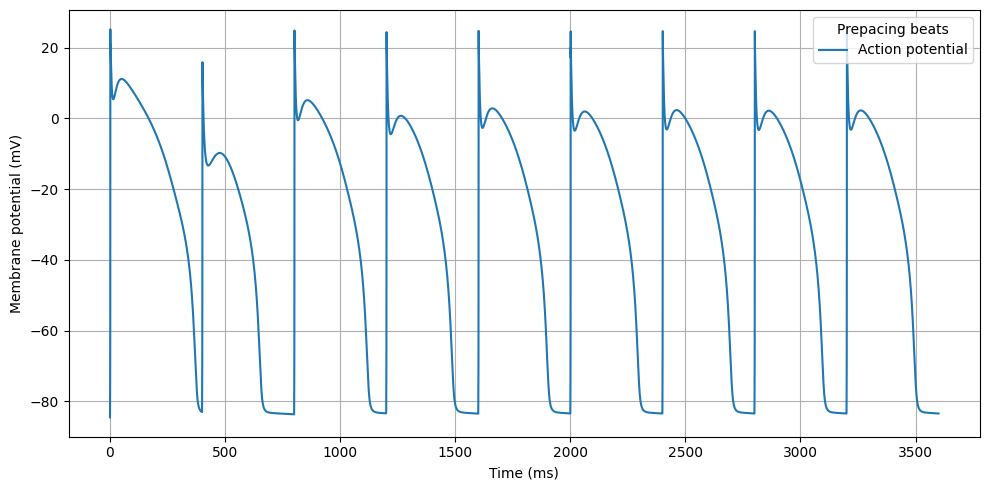

In [5]:
# plot the action potential to visualize prepacing beats stimuli
time = np.arange(len(action_pot_tracker.output)) * model.dt

fig, ax = plt.subplots(1, 1, figsize=(10, 5))  
plt.plot(time, action_pot_tracker.output, label="Action potential")
plt.legend(title='Prepacing beats')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Membrane potential (mV)')
plt.grid()
plt.tight_layout()
plt.show()

## Step 2: S2 stimulus

Restitution is assessed by applying a single S2 stimulus at progressively
shorter coupling intervals (i.e., varying delays after the last S1),
and measuring:
  - APD90: Action potential duration at 90% repolarization
  - DI: Diastolic interval (delay between end of S1 AP and start of S2)

Only the S2 response is simulated in each run, making the protocol fast
and scalable.

In [6]:
di_values = []
apd90_values = []

# Run S2 branches
for s2_delay in s2_intervals:
    stim_sequence = fw.StimSequence()
    s2_time = s2_delay
    stim_sequence.add_stim(fw.StimVoltageCoord2D(s2_time, stim_amp,
                                                 0, 5,
                                                 0, nj))

    tracker_sequence = fw.TrackerSequence()
    ap_tracker = fw.ActionPotential2DTracker()
    ap_tracker.cell_ind = [cell]
    ap_tracker.step = 1
    tracker_sequence.add_tracker(ap_tracker)

    model = fw.LuoRudy912D()
    model.dt = 0.01
    model.dr = 0.25
    model.t_max = 800  # allow repolarization
    model.cardiac_tissue = tissue
    model.stim_sequence = stim_sequence
    model.tracker_sequence = tracker_sequence
    model.state_loader = fw.StateLoader("s1_state")

    print(f"Running S2 at +{s2_delay} ms...")
    model.run()

    u = ap_tracker.output
    t = np.arange(len(u)) * model.dt

    # Find upstroke
    up = np.where((u[:-1] < threshold_up) & (u[1:] >= threshold_up))[0]
    if len(up) == 0:
        print(f"Loss of capture at S2 interval = {s2_delay} ms.")
        break
    ap_start = up[-1]

    peak = np.max(u[ap_start:])
    repol_level = peak - 0.9 * (peak - np.min(u[ap_start:]))
    repol_idx = np.where(u[ap_start:] < repol_level)[0]
    if len(repol_idx) == 0:
        continue
    ap_end = ap_start + repol_idx[0]
    apd90 = (ap_end - ap_start) * model.dt
    di = s2_delay

    if di <= 0:
        continue

    apd90_values.append(apd90)
    di_values.append(di)

Running S2 at +400 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:07<00:00, 11099.97it/s]


Running S2 at +375 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:06<00:00, 11452.43it/s]


Running S2 at +350 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:07<00:00, 10303.80it/s]


Running S2 at +325 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:07<00:00, 10199.24it/s]


Running S2 at +300 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:07<00:00, 10483.13it/s]


Running S2 at +275 ms...


Running LuoRudy912D: 100%|██████████████| 80000/80000 [00:08<00:00, 9968.72it/s]


Running S2 at +250 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:07<00:00, 10221.69it/s]


Running S2 at +225 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:07<00:00, 11230.84it/s]


Running S2 at +200 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:07<00:00, 10743.75it/s]


Running S2 at +175 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:07<00:00, 10595.38it/s]


Running S2 at +150 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:07<00:00, 10554.29it/s]


Running S2 at +125 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:06<00:00, 11687.73it/s]


Running S2 at +100 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:06<00:00, 11733.73it/s]


Running S2 at +75 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:06<00:00, 11506.06it/s]


Running S2 at +50 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:06<00:00, 11694.09it/s]


Running S2 at +25 ms...


Running LuoRudy912D: 100%|█████████████| 80000/80000 [00:07<00:00, 11361.14it/s]


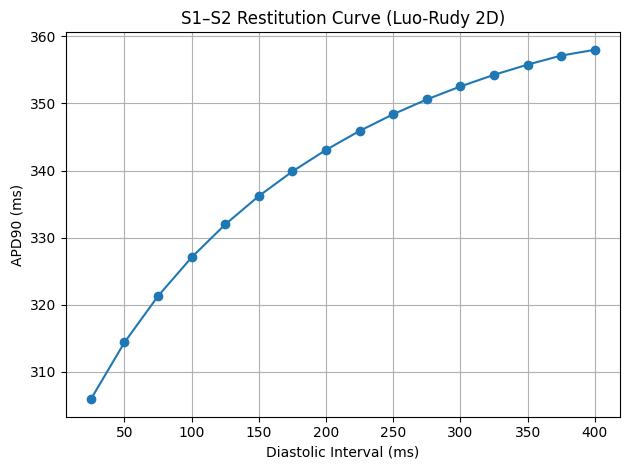

In [7]:
# Plot restitution curve
plt.figure()
plt.plot(di_values, apd90_values, 'o-')
plt.xlabel("Diastolic Interval (ms)")
plt.ylabel("APD90 (ms)")
plt.title("S1–S2 Restitution Curve (Luo-Rudy 2D)")
plt.grid()
plt.tight_layout()
plt.show()

# Cleanup saved state
shutil.rmtree("s1_state")